In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import cv2
from scipy.signal import butter, lfilter, freqz

import load_data
import pr2_utils as utils
from slam_utils import *

In [10]:
for i,j in np.ndindex((8,8)):
    print(i,j)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7


In [7]:
size = (4,4)
n = size[0]
basis_images = np.zeros((n,n,n,n))
for i,j in np.ndindex(size):
    basis_images[i,j,i,j] = 1.0
    transform = np.zeros(size)
    for u,v in np.ndindex(size):
        for x,y in np.ndindex(size):
            alpha_u = math.sqrt(1/n) if u == 0 else math.sqrt(2/n)
            alpha_v = math.sqrt(1/n) if v == 0 else math.sqrt(2/n)
            cos_x = math.cos((2*x+1)*u*math.pi/(2*n))
            cos_y = math.cos((2*y+1)*v*math.pi/(2*n))
            transform[u,v] += basis_images[i,j,x,y] * alpha_u * alpha_v * cos_x * cos_y

    basis_images[i,j] = transform

### Load Encoder, LIDAR, and IMU data

Number of encoder samples: 4956
Number of IMU samples: 12187
Number of LIDAR samples: 4962
LIDAR FOV stats (rad): min_angle = -2.356194, max_angle = 2.356194, angle_increment = 0.004363
LIDAR FOV stats (deg): min_angle = -135.000000, max_angle = 135.000000, angle_increment = 0.250000
LIDAR range stats (expected): min_range = 0.100000, max_range = 30.000000
LIDAR range stats (given)   : min_range = 0.001000, max_range = 20.952999
Number of RGB images = 2289, Disparity images = 2407


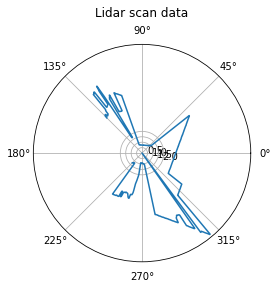

In [2]:
ds_idx = 20
encoder_counts, encoder_stamps = load_data.load_encoder_data(ds_idx)
imu_ang_vel, imu_lin_accln, imu_stamps = load_data.load_IMU_data(ds_idx)
lidar_angle_min, lidar_angle_max, lidar_angle_increment, lidar_range_min, lidar_range_max, lidar_ranges, lidar_stamps = load_data.load_lidar_data(ds_idx)
disp_stamps, rgb_stamps = load_data.load_kinectRGBD_data(ds_idx)

utils.show_lidar()

### Match closest-in-the-past timestamps between IMU, LIDAR and Encoder data using encoder as reference

In [3]:
imu_match_enc_idx, lidar_match_enc_idx = match_enc_imu_lidar_stamps(encoder_stamps, imu_stamps, lidar_stamps)
assert(imu_match_enc_idx.shape[0] == lidar_match_enc_idx.shape[0] == encoder_stamps.shape[0])

valid_lidar_scan = get_valid_lidar_scans(lidar_ranges)[lidar_match_enc_idx]   # (4956, 1081)

### Estimate LIDAR range measurements in robot body frame

In [4]:
# convert scan/range measurements from distances (in m) to (x,y,z) coordinates in LIDAR sensor frame
lidar_xyz_LF = compute_lidar_xyz_LF(lidar_ranges, lidar_angle_min, lidar_angle_max, lidar_angle_increment)

# convert from lidar sensor frame to robot body frame
lidar_xyz_RF = compute_lidar_xyz_RF(lidar_xyz_LF)  # (4962, 1081, 3)
lidar_xyz_RF = lidar_xyz_RF[lidar_match_enc_idx]              # (4956, 1081, 3)

### Estimate LIDAR range measurements in world frame for the first LIDAR scan

In [5]:
robot_pose_WF = np.zeros((4, 4))
robot_pose_WF[0:3, 0:3] = np.eye(3)
robot_pose_WF[0:3, 3] = np.zeros(3)
robot_pose_WF[3,3] = 1

lidar_xyz_WF = compute_lidar_xyz_WF(lidar_xyz_RF[0], robot_pose_WF)
print(lidar_xyz_WF.shape)

print(lidar_xyz_WF[..., 0].min(), lidar_xyz_WF[..., 0].max())
print(lidar_xyz_WF[..., 1].min(), lidar_xyz_WF[..., 1].max())
print(lidar_xyz_WF[..., 2].min(), lidar_xyz_WF[..., 2].max())

(1081, 3)
-3.3386641877300156 10.49137604799236
-4.5011150099577755 3.808645608594446
0.51435 0.51435


### Generate occupancy grid map for the very first lidar scan

100%|██████████| 1081/1081 [00:00<00:00, 6915.04it/s]


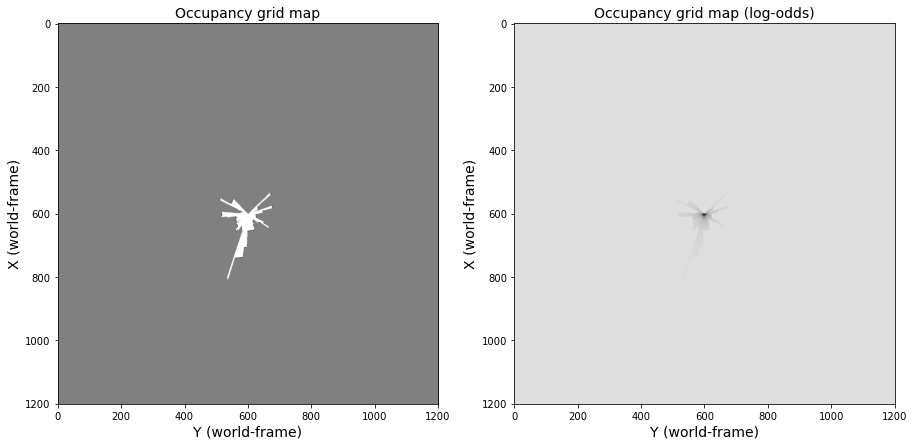

In [6]:
# create an occupancy grid map of certain resolution
init_scan_map, init_scan_map_logodds = gen_map_init_scan(lidar_xyz_WF, valid_lidar_scan[0])

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(init_scan_map, cmap='gray', vmin=np.min(init_scan_map), vmax=np.max(init_scan_map))
plt.ylabel("X (world-frame)", fontsize=14)
plt.xlabel("Y (world-frame)", fontsize=14)
plt.title("Occupancy grid map", fontsize=14)

plt.subplot(1,2,2)
plt.imshow(init_scan_map_logodds, cmap='gray', vmin=np.min(init_scan_map_logodds), vmax=np.max(init_scan_map_logodds))
plt.ylabel("X (world-frame)", fontsize=14)
plt.xlabel("Y (world-frame)", fontsize=14)
plt.title("Occupancy grid map (log-odds)", fontsize=14)
plt.show()

In [26]:
u, v = np.mgrid[0:5, 0:10]
print(u)
print(v)

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]],

       [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]])

### Predict robot trajectory with dead-reckoning (no noise) using differential drive motion model starting from (0,0,0) pose

In [12]:
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [17]:
1/np.mean(imu_stamps[1:] - imu_stamps[0:-1])

99.94111627774632

Robot linear velocity shape: (4956,)
Robot angular velocity shape: (12187,)


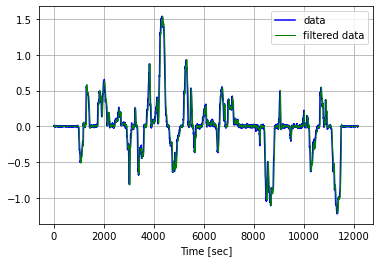

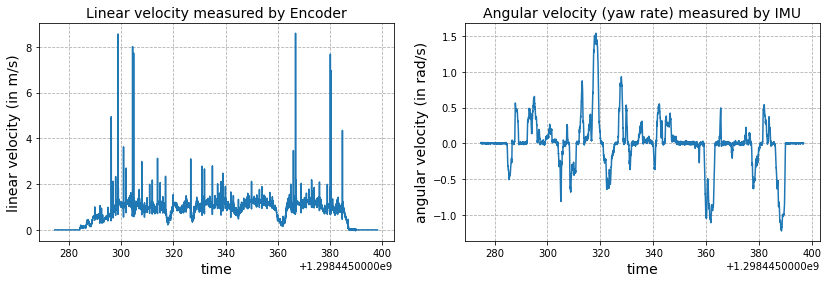

In [25]:
robot_lin_vel, robot_ang_vel = compute_robot_vel(encoder_counts, encoder_stamps, imu_ang_vel)



# Filter requirements.
order = 10
fs = 100.0       # sample rate, Hz
cutoff = 5.0  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
# b, a = butter_lowpass(cutoff, fs, order)

# Filter the data, and plot both the original and filtered signals.
filter_data = butter_lowpass_filter(robot_ang_vel, cutoff, fs, order)

plt.subplot(1, 1, 1)
plt.plot(robot_ang_vel, 'b-', label='data')
plt.plot(filter_data, 'g-', linewidth=1, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

# Plot the frequency response.
# w, h = freqz(b, a, fs=fs, worN=8000)
# plt.subplot(2, 1, 1)
# plt.plot(w, np.abs(h), 'b')
# plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
# plt.axvline(cutoff, color='k')
# plt.xlim(0, 0.5*fs)
# plt.title("Lowpass Filter Frequency Response")
# plt.xlabel('Frequency [Hz]')
# plt.grid()






plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(encoder_stamps, robot_lin_vel)
plt.xlabel("time", fontsize=14)
plt.ylabel("linear velocity (in m/s)", fontsize=14)
plt.title("Linear velocity measured by Encoder", fontsize=14)
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.plot(imu_stamps, robot_ang_vel)
plt.xlabel("time", fontsize=14)
plt.ylabel("angular velocity (in rad/s)", fontsize=14)
plt.title("Angular velocity (yaw rate) measured by IMU", fontsize=14)
plt.grid(linestyle='--')

plt.savefig("../plots/robot_vel.png")
plt.show()

### Predict robot motion with dead-reckoning (no noise)

In [8]:
robot_ang_vel_match = robot_ang_vel[imu_match_enc_idx]                  # (4956,)
robot_vel = np.array([robot_lin_vel, robot_ang_vel_match]).T            # (4956, 2)
# print(robot_lin_vel.shape, robot_ang_vel_match.shape, robot_vel.shape)

# predict a single particle trajectory with no noise using motion model
num_particles = 1
particle_traj_dead_reck = pred_particle_traj(robot_vel, encoder_stamps, num_particles=num_particles, 
                                            std_lin_vel=0, std_ang_vel=0, toshow=True)

100%|██████████| 4954/4954 [00:00<00:00, 22898.25it/s]


In [10]:
# test whether the "compute_lidar_xyz_WF" and "compute_lidar_xyz_WF_vect" are performing exactly the same
print(particle_traj_dead_reck.shape)
num_traj_steps = particle_traj_dead_reck.shape[1]

robot_traj_WF = particle_traj_dead_reck[0]
robot_se3pose_WF = get_se3pose_from_xytheta(robot_traj_WF)
print(robot_se3pose_WF.shape)

start_time = time.time()
lidar_xyz_WF_1 = np.zeros_like(lidar_xyz_RF)
for traj_idx in tqdm(range(num_traj_steps)):
    lidar_xyz_WF_1[traj_idx] = compute_lidar_xyz_WF(lidar_xyz_RF[traj_idx], robot_se3pose_WF[traj_idx])
print("time:", time.time() - start_time)

start_time = time.time()
lidar_xyz_WF_2 = compute_lidar_xyz_WF_vect(lidar_xyz_RF, robot_se3pose_WF)
print("time:", time.time() - start_time)

assert(np.all(lidar_xyz_WF_1.shape == lidar_xyz_WF_1.shape))
print(np.sum(np.abs(lidar_xyz_WF_1 - lidar_xyz_WF_2)))

(1, 4956, 3)
(4956, 4, 4)


100%|██████████| 4956/4956 [00:00<00:00, 23677.25it/s]


time: 0.326038122177124
time: 0.2994506359100342
0.0


In [9]:
# predict particle trajectories with some noise using motion model
num_particles = 5
particle_traj = pred_particle_traj(robot_vel, encoder_stamps, num_particles=num_particles, 
                                    std_lin_vel=0.5, std_ang_vel=0.05, toshow=True)

100%|██████████| 4954/4954 [00:00<00:00, 23466.06it/s]


In [12]:
# test the "get_SE3_pose_from_xytheta" function
xytheta = np.random.randint(0, 9, (50, 3))
se3_pose = get_se3pose_from_xytheta(xytheta)
print(se3_pose.shape)
xytheta = np.random.randint(0, 9, (50, 20, 3))
se3_pose = get_se3pose_from_xytheta(xytheta)
print(se3_pose.shape)

(50, 4, 4)
(50, 20, 4, 4)


### Generate occupancy grid map for robot trajectory with dead-reckoning

In [ ]:
# predict a single particle trajectory with no noise using motion model
num_particles = 1
robot_traj_dead_reck_WF = pred_particle_traj(robot_vel, encoder_stamps, num_particles=num_particles, 
                                            std_lin_vel=0, std_ang_vel=0, toshow=False)

grid_map, grid_map_logodds = gen_map_dead_reck(lidar_xyz_RF, LIDAR_SE3POSE_RF, robot_traj_dead_reck_WF[0], valid_lidar_scan)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(grid_map, cmap='gray', vmin=np.min(grid_map), vmax=np.max(grid_map))
plt.ylabel("X (world-frame)", fontsize=14)
plt.xlabel("Y (world-frame)", fontsize=14)
plt.title("Occupancy grid map", fontsize=14)

plt.subplot(1,2,2)
plt.imshow(grid_map_logodds, cmap='gray', vmin=np.min(grid_map_logodds), vmax=np.max(grid_map_logodds))
plt.ylabel("X (world-frame)", fontsize=14)
plt.xlabel("Y (world-frame)", fontsize=14)
plt.title("Occupancy grid map (log-odds)", fontsize=14)
plt.show()

  3%|▎         | 140/4956 [00:15<08:58,  8.95it/s]

In [28]:
def compute_map_correlation2(MAP, lidar_xyz_WF, xy_grid_9x9, num_particles=1):
    """
        MAP: dict of current occupancy grid map
        lidar_xyz_WF: (num_particles, 1081, 3)
    """
#     xy_grid_locs = np.array([np.arange(MAP['xmin'], MAP['xmax']+MAP['res'], MAP['res']), 
#                              np.arange(MAP['ymin'], MAP['ymax']+MAP['res'], MAP['res'])])
#     print("stage-1:", xy_grid_locs.shape)

    st = time.time()
    lidar_xyz_WF_9x9_phy_locs = temp_add(lidar_xyz_WF[:, :, 0:2], xy_grid_9x9)   # (num_particles, 1081, 2, 9, 9)
    print("stage-1:", time.time() - st)
    
    st = time.time()
    lidar_xyz_WF_9x9_phy_locs = np.random.randint(0, 9, (num_particles, 1081, 2, 9, 9))
    print("stage-2:", time.time() - st)
    
    st = time.time()
    lidar_xyz_WF_9x9_grid_locs = np.int16(np.round((lidar_xyz_WF_9x9_phy_locs - MAP['xmin']) / MAP['res']))
    print("stage-3:", time.time() - st)
#     print("stage-3:", lidar_xyz_WF_9x9_grid_locs.shape)
    
    st = time.time()
    valid_xloc = np.logical_and(lidar_xyz_WF_9x9_grid_locs[:,:,0] >= 0, lidar_xyz_WF_9x9_grid_locs[:,:,0] < MAP['sizex'])
    valid_yloc = np.logical_and(lidar_xyz_WF_9x9_grid_locs[:,:,1] >= 0, lidar_xyz_WF_9x9_grid_locs[:,:,1] < MAP['sizey'])
    valid_grid_locs = np.logical_and(valid_xloc, valid_yloc)      # (num_particles, 1081, 9, 9)
    print("stage-4:", time.time() - st)
    
#     print("stage-4:", np.unique(valid_grid_locs), valid_grid_locs.shape)
    
    x_locs = lidar_xyz_WF_9x9_grid_locs[:,:,0,:,:]   # (num_particles, 1081, 9, 9)
    y_locs = lidar_xyz_WF_9x9_grid_locs[:,:,1,:,:]   # (num_particles, 1081, 9, 9)

    st = time.time()
    x_locs = np.multiply(x_locs, valid_grid_locs)
    y_locs = np.multiply(y_locs, valid_grid_locs)
    print("stage-6:", time.time() - st)

    st = time.time()
    valid_map = MAP['map'][x_locs, y_locs]            # (num_particles, 1081, 9, 9)
    print("stage-7:", time.time() - st)
#     print("stage-5:", valid_map.shape)
    
    st = time.time()
    corr_mat = np.sum(valid_map, axis=1)             # (num_particles, 9, 9)
    print("stage-8:", time.time() - st)
#     print("stage-6:", corr_mat.shape)

    return corr_mat

In [78]:
# def compute_map_correlation2(MAP, lidar_xyz_WF, num_particles=1):
#     """
#         MAP: dict of current occupancy grid map
#         lidar_xyz_WF: (num_particles, 1081, 3)
#         xy_grid_9x9: 
#     """
#     MAP['map'][0,0] = 0
#     num_particles, num_scan_ang = lidar_xyz_WF.shape[0:2]
#     part_corr_mat = np.zeros((num_particles, 9, 9))
    
#     lidar_x = lidar_xyz_WF[:, :, 0]   # (num_particles, 1081)
#     lidar_y = lidar_xyz_WF[:, :, 1]   # (num_particles, 1081)
    
    

#     for u in range(0, 9):
    
#         xy_grid_9x9_WF = lidar_x + xs[u]

#         xy_grid_9x9_WF_cells = np.int16(np.round((xy_grid_9x9_WF - MAP['xmin']) / MAP['res']))

#         valid_xloc = np.logical_and(xy_grid_9x9_WF_cells[:,:,0] >= 0, xy_grid_9x9_WF_cells[:,:,0] < MAP['sizex'])
#         valid_yloc = np.logical_and(xy_grid_9x9_WF_cells[:,:,1] >= 0, xy_grid_9x9_WF_cells[:,:,1] < MAP['sizey'])
#         valid_grid_locs = np.logical_and(valid_xloc, valid_yloc)

#         x_locs = xy_grid_9x9_WF_cells[:,:,0]   # (9,9)
#         y_locs = xy_grid_9x9_WF_cells[:,:,1]   # (9,9)
#         x_locs = np.multiply(x_locs, valid_grid_locs)
#         y_locs = np.multiply(y_locs, valid_grid_locs)

#         part_corr_mat[part_idx] += MAP['map'][x_locs, y_locs]

#     return part_corr_mat

100%|██████████| 100/100 [00:21<00:00,  4.56it/s]


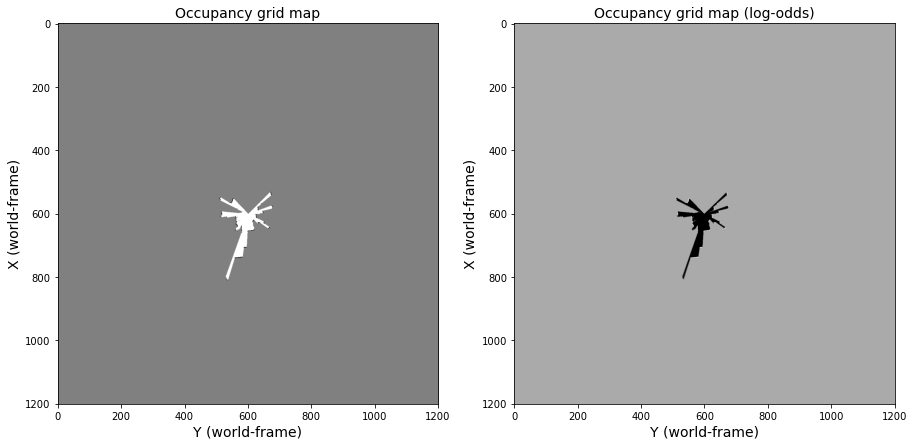

In [38]:
num_particles = 100
update_skip = 5

MAP = get_empty_map()
MAP['map'] = np.copy(init_scan_map)
MAP['logodds'] = np.copy(init_scan_map_logodds)
MAP['map'][0,0] = 0

# xy_grid_9x9 = np.meshgrid(np.arange(-0.2, 0.2+MAP['res'], MAP['res']), 
#                           np.arange(-0.2, 0.2+MAP['res'], MAP['res']))   # (9,9), (9,9)
# xy_grid_9x9 = np.stack((xy_grid_9x9[1], xy_grid_9x9[0]), axis=2)       # (9, 9, 2)

# initialize the particle states and weights
particle_states = np.zeros((num_particles, 3))
particle_weights = np.full((num_particles), 1./num_particles)

tau_t = encoder_stamps[1:] - encoder_stamps[0:-1]     # (4955,)

num_scan_ang = lidar_xyz_RF.shape[1]
num_traj_steps = encoder_stamps.shape[0] - 1

xs = np.arange(-0.2, 0.2+0.05, 0.05)   # (9,)
ys = np.arange(-0.2, 0.2+0.05, 0.05)   # (9,)

for traj_idx in tqdm(range(0, 100)):
    particle_states = motion_model(particle_states, robot_vel[traj_idx], tau_t[traj_idx], 
                                   std_lin_vel=0.1, std_ang_vel=0.05)                      # (num_particles, 3)
    
    if traj_idx % update_skip == 0:
        continue

    # convert particle xytheta in WF to 4x4 SE(3) pose in WF
    particle_se3pose_WF = get_se3pose_from_xytheta(particle_states)   # (num_particles, 4, 4)
    
    # take the lidar xyz points and convert to world frame using each particle's pose
    lidar_xyz_WF = compute_lidar_xyz_WF_vect2(lidar_xyz_RF[traj_idx], particle_se3pose_WF)  # (num_particles, 1081, 3)
    
    # compute map correlation between lidar xyz points corresponding to each particle's pose
    corr_mat = compute_map_correlation(MAP, lidar_xyz_WF, xs, ys)      # (num_particles, 9, 9)
    
    # find the best correlation location for each particle
#     corr_per_particle = np.sum(np.sum(corr_mat, axis=2), axis=1)    # (num_particles)
    corr_per_particle = np.max(np.max(corr_mat, axis=2), axis=1)
    
#     corr_prob_per_particle = corr_per_particle / np.sum(corr_per_particle)
#     corr_prob_per_particle = np.exp(corr_per_particle) / np.sum(np.exp(corr_per_particle))
       
    # update the weights of each particle
    particle_weights = np.multiply(particle_weights, corr_per_particle) / np.dot(particle_weights, corr_per_particle)
    assert(np.abs(np.sum(particle_weights) - 1.) <= 1e-6)
    
    # find the particle with the highest weights after update
    best_particle_idx = np.argmax(particle_weights)

    # check if the effective number of particles is less than some threshold
    num_eff_particles = 1./np.dot(particle_weights, particle_weights)
    
    if num_eff_particles <= num_particles / 10:
        # if true, then resample the particle set (states, weights)
        # sample randomly from set {0,2,...,N-1} with particle weights as probability
        draw_set = np.random.choice(np.arange(0, num_particles), size=num_particles, p=particle_weights)
        particle_states = particle_states[draw_set, :]
        particle_weights = np.full((num_particles), 1./num_particles)
    
    # update the map using the best particle's pose
    best_particle_state = np.expand_dims(particle_states[best_particle_idx, :], axis=0)   # (1, 3)
    best_particle_se3pose_WF = get_se3pose_from_xytheta(best_particle_state)             # (1, 4, 4)

    # convert lidar scans from current time step to WF using best particle's se3pose
    lidar_xyz_WF_BP = compute_lidar_xyz_WF_vect2(lidar_xyz_RF[traj_idx], best_particle_se3pose_WF)  # (1, 1081, 3)
    
    # convert from meters to cell index
    ex_cells = np.ceil((lidar_xyz_WF_BP[0, :, 0] - MAP['xmin']) / MAP['res']).astype(np.int16) - 1  # (1081,)
    ey_cells = np.ceil((lidar_xyz_WF_BP[0, :, 1] - MAP['ymin']) / MAP['res']).astype(np.int16) - 1  # (1081,)
    
    sx = best_particle_state[0, 0] + LIDAR_SE3POSE_RF[0, 3]
    sy = best_particle_state[0, 1] + LIDAR_SE3POSE_RF[1, 3]

    sx_cells = np.ceil((sx - MAP['xmin']) / MAP['res']).astype(np.int16) - 1
    sy_cells = np.ceil((sy - MAP['ymin']) / MAP['res']).astype(np.int16) - 1
    
    for scan_idx in range(num_scan_ang):        
        ray_x, ray_y = utils.bresenham2D(sx=sx_cells, sy=sy_cells, 
                                         ex=ex_cells[scan_idx], ey=ey_cells[scan_idx]).astype(np.int16)

        valid_xy = np.logical_and(np.logical_and(ray_x >= 0, ray_x < MAP['sizex']), 
                                  np.logical_and(ray_y >= 0, ray_y < MAP['sizey']))
            
        ray_x = ray_x[valid_xy]
        ray_y = ray_y[valid_xy]
        
        if ray_x.shape[0] == 0:
            continue

        # update the map logodds
        MAP['logodds'][ray_x[:-1], ray_y[:-1]] -= LOG4   # free
        MAP['logodds'][ray_x[-1], ray_y[-1]] += LOG4     # occupied

    # constrain log-odds map to avoid overconfident estimation
    MAP['logodds'] = np.clip(MAP['logodds'], a_min=-100, a_max=50)
    temp = 1. / (1 + np.exp(MAP['logodds']))
    MAP['map'][temp > 0.5] = 1.
    MAP['map'][temp < 0.5] = 0
    MAP['map'][temp == 0.5] = 0.5


plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(MAP['map'], cmap='gray', vmin=np.min(MAP['map']), vmax=np.max(MAP['map']))
plt.ylabel("X (world-frame)", fontsize=14)
plt.xlabel("Y (world-frame)", fontsize=14)
plt.title("Occupancy grid map", fontsize=14)

plt.subplot(1,2,2)
plt.imshow(MAP['logodds'], cmap='gray', vmin=np.min(MAP['logodds']), vmax=np.max(MAP['logodds']))
plt.ylabel("X (world-frame)", fontsize=14)
plt.xlabel("Y (world-frame)", fontsize=14)
plt.title("Occupancy grid map (log-odds)", fontsize=14)

plt.savefig("../plots/ds"+str(ds_idx)+"/map_pf_update.png")
plt.show()

# plot the particle dead-reck trajectory inside the map
map_dead_reck_with_traj = np.zeros((map_dead_reck.shape[0], map_dead_reck.shape[1], 3))
map_dead_reck_with_traj[:,:,0] = np.copy(map_dead_reck)
map_dead_reck_with_traj[:,:,1] = np.copy(map_dead_reck)
map_dead_reck_with_traj[:,:,2] = np.copy(map_dead_reck)

# convert particle traj from meters to cells coordinates
traj_dead_reck_WF_cells = np.ceil((traj_dead_reck_WF[0, :, 0:2] - MAP_XMIN) / MAP_RES).astype(np.int16) - 1  # (4956, 2)
map_dead_reck_with_traj[traj_dead_reck_WF_cells[:,0], traj_dead_reck_WF_cells[:,1]] = [1,0,0]

plt.figure(figsize=(8,8))
plt.imshow(map_dead_reck_with_traj)
plt.ylabel("X (world-frame)", fontsize=14)
plt.xlabel("Y (world-frame)", fontsize=14)
plt.title("Occupancy grid map with particle traj", fontsize=14)

plt.savefig("../plots/ds"+str(args.ds_idx)+"/map_dead_reck_with_traj.png")
plt.show()

In [39]:
np.unique(MAP['map'])

array([1.9287499e-22, 1.9287792e-22, 1.9288602e-22, 2.1175819e-22,
       2.1177356e-22, 7.7150071e-22, 3.3881378e-21, 3.3881895e-21,
       3.3882287e-21, 1.3552564e-20, 1.3552978e-20, 5.4210309e-20,
       5.4213204e-20, 2.1684147e-19, 2.1684310e-19, 2.1684723e-19,
       2.1684806e-19, 7.9002040e-19, 8.6736660e-19, 3.4694697e-18,
       3.4695888e-18, 1.3877892e-17, 1.3877945e-17, 5.5511628e-17,
       2.0224602e-16, 2.2204672e-16, 2.2204839e-16, 3.5527539e-15,
       1.4211004e-14, 1.4211029e-14, 5.6843961e-14, 5.6844178e-14,
       2.2737563e-13, 9.0950153e-13, 9.0950500e-13, 9.0950858e-13,
       3.6380027e-12, 3.6385092e-12, 1.3254799e-11, 5.8209486e-11,
       5.8210159e-11, 2.3283153e-10, 2.3283331e-10, 9.3132513e-10,
       9.3136432e-10, 9.3136598e-10, 3.3931900e-09, 3.7252974e-09,
       3.7253116e-09, 3.7256385e-09, 1.4901175e-08, 1.4902454e-08,
       1.4902909e-08, 5.9604645e-08, 5.9606570e-08, 2.1716370e-07,
       2.3841852e-07, 2.3842850e-07, 9.5367341e-07, 3.4746213e

In [18]:
a = np.meshgrid(np.arange(0, 5, 1), np.arange(0, 5, 1))
print(a[0])
print(a[1])

b = np.stack((a[1], a[0]), axis=2)
print(b[:,:,0])

[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]


In [14]:
a = np.arange(-0.2, 0.2+0.05, 0.05)
b = np.meshgrid(a, a)     
print(b[0].shape, b[1].shape)

c = np.stack((b[1], b[0]), axis=2)
print(c.shape)

print(c[0, :, :])

(9, 9) (9, 9)
(9, 9, 2)
[[-2.00000000e-01 -2.00000000e-01]
 [-2.00000000e-01 -1.50000000e-01]
 [-2.00000000e-01 -1.00000000e-01]
 [-2.00000000e-01 -5.00000000e-02]
 [-2.00000000e-01 -5.55111512e-17]
 [-2.00000000e-01  5.00000000e-02]
 [-2.00000000e-01  1.00000000e-01]
 [-2.00000000e-01  1.50000000e-01]
 [-2.00000000e-01  2.00000000e-01]]


In [135]:
a = np.random.randint(1, 2, (4, 1081, 2))
b = np.random.randint(2, 3, (9, 9, 2))

# print(np.unique(a))
# print(np.unique(b))

b1 = np.transpose(b, (2, 0, 1))
b2 = np.expand_dims(b1, 0)
b3 = np.repeat(b2, 1081, axis=0)
b4 = np.expand_dims(b3, 0)
b5 = np.repeat(b4, 4, axis=0)

a1 = np.expand_dims(a, axis=3)
a2 = np.repeat(a1, 9, axis=3)
a3 = np.expand_dims(a2, axis=4)
a4 = np.repeat(a3, 9, axis=4)

c = a4 + b5

print(c.shape)
print(np.unique(c))

(4, 1081, 2, 9, 9)
[3]


In [65]:
def mapCorrelation(im, x_im, y_im, vp, xs, ys):
    '''
        INPUT 
        im              the map 
        x_im,y_im       physical x,y positions of the grid map cells
        vp[0:2,:]       occupied x,y positions from range sensor (in physical unit)  
        xs,ys           physical x,y,positions you want to evaluate "correlation" 

        OUTPUT 
        c               sum of the cell values of all the positions hit by range sensor
    '''
    nx, ny = im.shape

    xmin = x_im[0]
    xmax = x_im[-1]
    xresolution = (xmax-xmin)/(nx-1)
    
    ymin = y_im[0]
    ymax = y_im[-1]
    yresolution = (ymax-ymin)/(ny-1)
    
    nxs = xs.size
    nys = ys.size
    cpr = np.zeros((nxs, nys))
    
    print("what:", xs, ys)
    
    for jy in range(0,nys):
        y1 = vp[1,:] + ys[jy] # 1 x 1076
        iy = np.int16(np.round((y1-ymin)/yresolution))
        for jx in range(0,nxs):
            x1 = vp[0,:] + xs[jx] # 1 x 1076
            ix = np.int16(np.round((x1-xmin)/xresolution))
            valid = np.logical_and( np.logical_and((iy >=0), (iy < ny)), \
                                        np.logical_and((ix >=0), (ix < nx)))
            cpr[jx,jy] = np.sum(im[ix[valid],iy[valid]])
    
    return cpr

hey: (1081,)
This is Y: (2, 1076)
(9,) (9,)
Testing map_correlation with 801x801 cells
what: [-2.00000000e-01 -1.50000000e-01 -1.00000000e-01 -5.00000000e-02
 -5.55111512e-17  5.00000000e-02  1.00000000e-01  1.50000000e-01
  2.00000000e-01] [-2.00000000e-01 -1.50000000e-01 -1.00000000e-01 -5.00000000e-02
 -5.55111512e-17  5.00000000e-02  1.00000000e-01  1.50000000e-01
  2.00000000e-01]
Time taken: 0.005663394927978516
This c: (9, 9)
...Test passed.


/tmp/ipykernel_33464/2860924819.py:75: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax3 = fig3.gca(projection='3d')


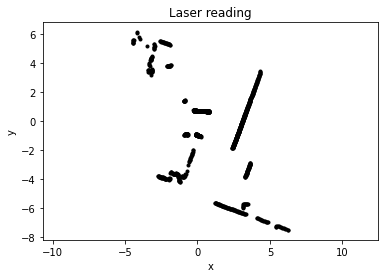

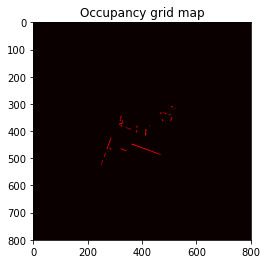

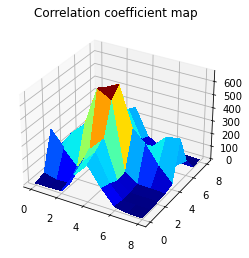

In [66]:
angles = np.arange(-135,135.25,0.25)*np.pi/180.0
ranges = np.load("test_ranges.npy")
print("hey:", ranges.shape)

# take valid indices
indValid = np.logical_and((ranges < 30),(ranges> 0.1))
ranges = ranges[indValid]
angles = angles[indValid]

# init MAP
MAP = get_empty_map()

# xy position in the sensor frame
xs0 = ranges*np.cos(angles)
ys0 = ranges*np.sin(angles)

# convert position in the map frame here 
Y = np.stack((xs0,ys0))
print("This is Y:", Y.shape)

# convert from meters to cells
xis = np.ceil((xs0 - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
yis = np.ceil((ys0 - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

# build an arbitrary map 
indGood = np.logical_and(np.logical_and(np.logical_and((xis > 1), (yis > 1)), (xis < MAP['sizex'])), (yis < MAP['sizey']))
MAP['map'][xis[indGood[0]],yis[indGood[0]]] = 1

x_im = np.arange(MAP['xmin'],MAP['xmax']+MAP['res'],MAP['res']) # x-positions of each pixel of the map
y_im = np.arange(MAP['ymin'],MAP['ymax']+MAP['res'],MAP['res']) # y-positions of each pixel of the map
# print(x_im[0], x_im[-1], y_im[0], y_im[-1])

x_range = np.arange(-0.2,0.2+0.05,0.05)
y_range = np.arange(-0.2,0.2+0.05,0.05)

print(x_range.shape, y_range.shape)

print("Testing map_correlation with {}x{} cells".format(MAP['sizex'],MAP['sizey']))
start_time = time.time()
c = mapCorrelation(MAP['map'],x_im,y_im,Y,x_range,y_range)
print("Time taken:", time.time() - start_time)

print("This c:", c.shape)

c_ex = np.array([[3,4,8,162,270,132,18,1,0],
      [25  ,1   ,8   ,201  ,307 ,109 ,5  ,1   ,3],
      [314 ,198 ,91  ,263  ,366 ,73  ,5  ,6   ,6],
      [130 ,267 ,360 ,660  ,606 ,87  ,17 ,15  ,9],
      [17  ,28  ,95  ,618  ,668 ,370 ,271,136 ,30],
      [9   ,10  ,64  ,404  ,229 ,90  ,205,308 ,323],
      [5   ,16  ,101 ,360  ,152 ,5   ,1  ,24  ,102],
      [7   ,30  ,131 ,309  ,105 ,8   ,4  ,4   ,2],
      [16  ,55  ,138 ,274  ,75  ,11  ,6  ,6   ,3]])

if np.sum(c==c_ex) == np.size(c_ex):
  print("...Test passed.")
else:
  print("...Test failed. Close figures to continue tests.")	

#plot original lidar points
fig1 = plt.figure()
plt.plot(xs0,ys0,'.k')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Laser reading")
plt.axis('equal')

#plot map
fig2 = plt.figure()
plt.imshow(MAP['map'],cmap="hot");
plt.title("Occupancy grid map")

#plot correlation
fig3 = plt.figure()
ax3 = fig3.gca(projection='3d')
X, Y = np.meshgrid(np.arange(0,9), np.arange(0,9))
ax3.plot_surface(X,Y,c,linewidth=0,cmap=plt.cm.jet, antialiased=False,rstride=1, cstride=1)
plt.title("Correlation coefficient map")  
plt.show()

# Texture Mapping

1. Read the disparity image as $\tt{uint16}$ and get RGB correspondences ($$rgbi, rgbj, RGB_{val}$$) from the above code.

2. Transform these $$rgbi, rgbj$$ pixel coordinates to Optical frame coordinates using @349.

3. Transform these optical frame coordinates to regular camera frame coordinates using $${}_oR_r^{-1}\begin{bmatrix} X_o\\Y_o\\Z_o \end{bmatrix} = \begin{bmatrix} X_r\\Y_r\\Z_r \end{bmatrix}$$.

4. Transform these regular frame coordinates to body frame coordinates (robot origin). You need to refer the robot dimensions from the drawing file, and get Roll, Pitch, Yaw angles from the project statement.

5. Transform these body frame coordinates to world frame coordinates using the extrinsic matrix. The current robot pose in world coordinates will be the extrinsic matrix.

6. Scale the world frame coordinates if you are applying a resolution to your map.

7. Insert the RGB values from step-1 in this map, i.e., you can initialize a 3D array of zeros of shape $$(xlim, ylim, 3)$$, and insert the RGB values to this array.

(480, 640, 3)


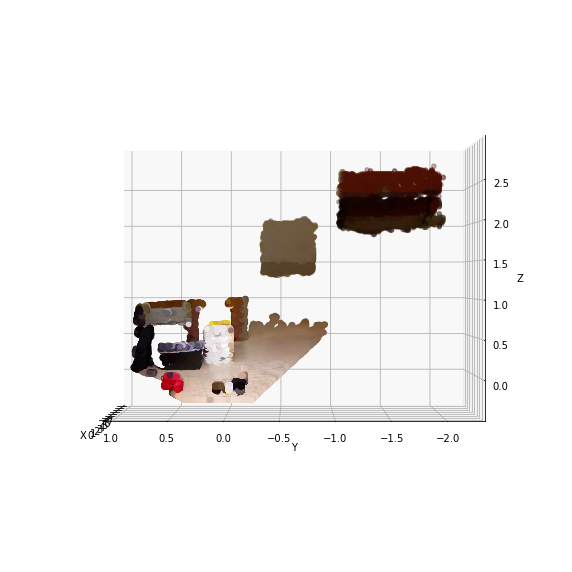

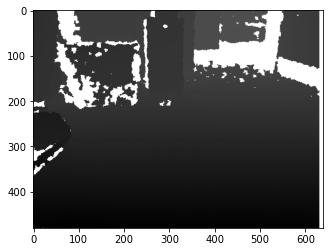

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

disp_path = "../data/dataRGBD/Disparity20/"
rgb_path = "../data/dataRGBD/RGB20/"

def normalize(img):
    max_ = img.max()
    min_ = img.min()
    return (img - min_)/(max_-min_)

if __name__ == '__main__':
  
  # load RGBD image
  imd = cv2.imread(disp_path+'disparity20_1.png',cv2.IMREAD_UNCHANGED) # (480 x 640)
  imc = cv2.imread(rgb_path+'rgb20_1.png')[...,::-1] # (480 x 640 x 3)

  print(imc.shape)
  
  # convert from disparity from uint16 to double
  disparity = imd.astype(np.float32)
  
  # get depth
  dd = (-0.00304 * disparity + 3.31)
  z = 1.03 / dd
  
  # calculate u and v coordinates 
  v,u = np.mgrid[0:disparity.shape[0],0:disparity.shape[1]]
  #u,v = np.meshgrid(np.arange(disparity.shape[1]),np.arange(disparity.shape[0]))
  
  # get 3D coordinates 
  fx = 585.05108211
  fy = 585.05108211
  cx = 315.83800193
  cy = 242.94140713
  x = (u-cx) / fx * z
  y = (v-cy) / fy * z
  
  # calculate the location of each pixel in the RGB image
  rgbu = np.round((u * 526.37 + dd*(-4.5*1750.46) + 19276.0)/fx)
  rgbv = np.round((v * 526.37 + 16662.0)/fy)
  valid = (rgbu>= 0)&(rgbu < disparity.shape[0])&(rgbv>=0)&(rgbv<disparity.shape[1])
  
  # display valid RGB pixels
  fig = plt.figure(figsize=(10, 13.3))
  ax = fig.add_subplot(projection='3d')
  ax.scatter(z[valid],-x[valid],-y[valid],c=imc[rgbv[valid].astype(int),rgbu[valid].astype(int)]/255.0)
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.view_init(elev=0, azim=180)
  plt.show()

  # display disparity image
  plt.imshow(normalize(imd), cmap='gray')
  plt.show()


In [9]:
def normalize(img):
    max_ = img.max()
    min_ = img.min()
    return (img - min_)/(max_- min_)

In [13]:
# # iterate over all disparity and RGB images
# def load_images_from_folder(folder):
#     images = []
#     count = 0
#     for filename in os.listdir(folder):
#         count += 1
# #         img = cv2.imread(os.path.join(folder,filename))
# #         if img is not None:
# #             images.append(img)
#     print("Number of images:", count)
#     return images

100%|██████████| 2289/2289 [03:33<00:00, 10.72it/s]


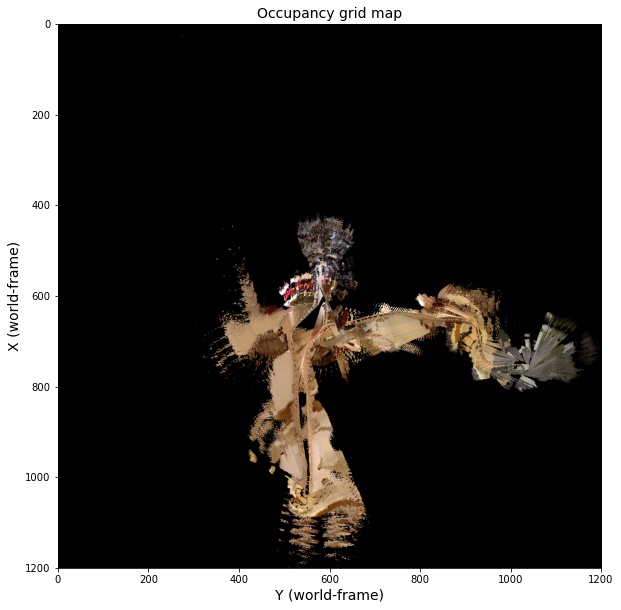

In [15]:
# create a second grid map for rgb colors
texture_map = get_texture_map()

# read images from the rgb dir and read corresponding disparity image
for img_idx in tqdm(range(rgb_stamps.shape[0])):
# for img_idx in tqdm(range(100)):
    
    rgb_img_path = os.path.join(rgb_dir, "rgb"+str(ds_idx)+"_"+str(img_idx+1)+".png")
    rgb_img = cv2.imread(rgb_img_path)[...,::-1]                      # (480 x 640 x 3)
    
    corr_disp_img_idx = disp_match_rgb_idx[img_idx]
    
    disp_img_path = os.path.join(disp_dir, "disparity"+str(ds_idx)+"_"+str(corr_disp_img_idx+1)+".png")
    
    # convert disparity from uint16 to double
    disp_img = cv2.imread(disp_img_path, cv2.IMREAD_UNCHANGED).astype(np.float32)           # (480 x 640)
    img_height, img_width = disp_img.shape
    
    # get depth image
    dd = -0.00304 * disp_img + 3.31
    depth_img = 1.03 / dd            # (480, 640)
    
    # calculate u and v coordinates 
    u, v = np.mgrid[0:img_height, 0:img_width]

#     y = (u - cu) / fu * z
#     x = (v - cv) / fu * z
    
    # calculate the location of each pixel in the RGB image
    rgbu = np.round((u * 526.37 + dd * (-4.5 * 1750.46) + 19276.0) / fu)  # (480, 640)
    rgbv = np.round((v * 526.37 + 16662.0) / fv)                          # (480, 640)
    valid_locs = (rgbu >= 0)&(rgbu < img_height)&(rgbv >= 0)&(rgbv < img_width)   # (480, 640)
    
    rgb_px_coords = np.zeros((img_height, img_width, 3))
    rgb_px_coords[:,:,0] = np.copy(rgbu)
    rgb_px_coords[:,:,1] = np.copy(rgbv)
    rgb_px_coords[:,:,2] = 1.0
    
    # convert from pixel coordinates to camera optical frame
    tmp1 = np.multiply(rgb_px_coords, np.repeat(np.expand_dims(depth_img, axis=2), 3, axis=2))  # (480, 640, 3)
    rgb_coords_OF = np.matmul(tmp1, Kinv.T)   # (480, 640, 3)

    # convert from camera optical frame to regular frame
    rot_mat_RGF2OF = np.array([[0, -1, 0], [0, 0, -1], [1, 0, 0]])  # (3,3)
    rgb_coords_RGF = np.matmul(rgb_coords_OF, np.linalg.inv(rot_mat_RGF2OF).T)  # (480, 640, 3)
    
    # convert from regular frame to robot body frame
    rgb_coords_RF = np.matmul(rgb_coords_RGF, KINECT_SE3POSE_RF[0:3,0:3].T) + KINECT_SE3POSE_RF[0:3,3]   # (480, 640, 3)
    
    # convert from robot body frame to world frame
    robot_rotmat_WF = robot_se3pose_WF[img_idx, 0:3, 0:3]
    robot_origin_WF = robot_se3pose_WF[img_idx, 0:3, 3]
    
    rgb_coords_WF = np.matmul(rgb_coords_RF, robot_rotmat_WF.T) + robot_origin_WF   # (480, 640, 3)
    rgb_coords_WF_cells = np.ceil((rgb_coords_WF[:,:,0:2] - MAP_XMIN) / MAP_RES).astype(np.int16) - 1  # (480, 640, 2)
    
    x_locs = rgb_coords_WF_cells[:,:,0]
    y_locs = rgb_coords_WF_cells[:,:,1]
    
    valid_locs_2 = np.logical_and(np.logical_and(x_locs >= 0, x_locs < 1201), 
                                  np.logical_and(x_locs >= 0, y_locs < 1201))    # (480, 640)
    
    final_valid_locs = np.logical_and(valid_locs, valid_locs_2)
    texture_map['map'][x_locs[final_valid_locs], y_locs[final_valid_locs]] = rgb_img[rgbu[final_valid_locs].astype(int), 
                                                                                     rgbv[final_valid_locs].astype(int)] / 255.0




[[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [477 477 477 ... 477 477 477]
 [478 478 478 ... 478 478 478]
 [479 479 479 ... 479 479 479]]
[[  0   1   2 ... 637 638 639]
 [  0   1   2 ... 637 638 639]
 [  0   1   2 ... 637 638 639]
 ...
 [  0   1   2 ... 637 638 639]
 [  0   1   2 ... 637 638 639]
 [  0   1   2 ... 637 638 639]]


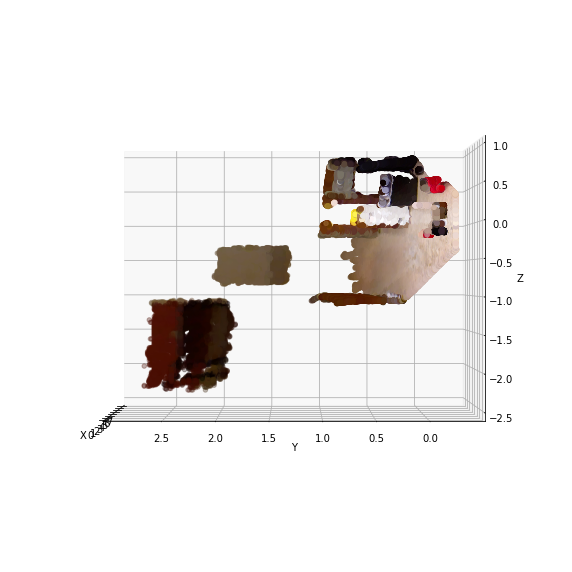

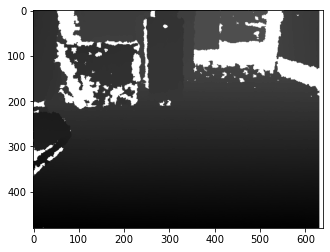

In [3]:
# load RGBD image
disp_img = cv2.imread(disp_path+'disparity20_1.png', cv2.IMREAD_UNCHANGED)  # (480 x 640)
rgb_img = cv2.imread(rgb_path+'rgb20_1.png')[...,::-1]   # (480 x 640 x 3)
img_height, img_width = disp_img.shape

# convert disparity from uint16 to double
disp_img = disp_img.astype(np.float32)

# get depth image
dd = -0.00304 * disp_img + 3.31
depth_img = 1.03 / dd            # (480, 640)

# calculate u and v coordinates 
u, v = np.mgrid[0:img_height, 0:img_width]
# u,v = np.meshgrid(np.arange(disparity.shape[1]),np.arange(disparity.shape[0]))
print(u)
print(v)

# get 3D coordinates 
fu = 585.05108211
fv = 585.05108211
cu = 242.94140713
cv = 315.83800193

x = (u - cu) / fu * z
y = (v - cv) / fu * z

# calculate the location of each pixel in the RGB image
rgbu = np.round((u * 526.37 + dd * (-4.5 * 1750.46) + 19276.0) / fu)
rgbv = np.round((v * 526.37 + 16662.0) / fv)

valid_locs = (rgbu >= 0)&(rgbu < img_height)&(rgbv >= 0)&(rgbv < img_width)

# display valid RGB pixels
fig = plt.figure(figsize=(10, 13.3))
ax = fig.add_subplot(projection='3d')
ax.scatter(depth_img[valid_locs], -x[valid_locs], -y[valid_locs], 
           c=rgb_img[rgbu[valid_locs].astype(int), rgbv[valid_locs].astype(int)] / 255.0
          )

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=0, azim=180)
plt.show()

# display disparity image
plt.imshow(normalize(disp_img), cmap='gray')
plt.show()